# Exploring shelter outcomes dataset
___
**Possible outcomes for shelter pets:** *adoption*, *transfer*, *return to owner*, *died*, *euthanasia*.

In [6]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
palette = sns.color_palette()

sns.set(font_scale=1.5)
%matplotlib inline

In [2]:
dataurl = '/Users/dbricare/Documents/Python/datasets/shelter-outcomes/'
df = pd.read_csv(dataurl+'train.csv', sep=',', encoding='utf-8')
print('(Rows, Columns):',df.shape)
df.head()

(Rows, Columns): (26729, 10)


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [3]:
# Convert ages to days

serages = df['AgeuponOutcome'][df['AgeuponOutcome'].notnull()]
keys = sorted(list(serages.str.extract('(\w+$)', expand=False).unique()))
print(keys)

# create dictionary for conversion

vals = [1,1,365//12,365//12,7,7,365,365]
dperiod = dict(zip(keys,vals))
print(dperiod)

def convage(age):
    if isinstance(age, float):
        return age
    else:
        num = int(re.match('\d+',age).group())
        period = re.search('\w+$', age).group()
        return float(num*dperiod[period])

df['AgeuponOutcome'] = df['AgeuponOutcome'].apply(convage)
df.head()

['day', 'days', 'month', 'months', 'week', 'weeks', 'year', 'years']
{'years': 365, 'day': 1, 'month': 30, 'days': 1, 'year': 365, 'week': 7, 'months': 30, 'weeks': 7}


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,365.0,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,365.0,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,730.0,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,21.0,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,730.0,Lhasa Apso/Miniature Poodle,Tan


## Breakdown of cats and dogs

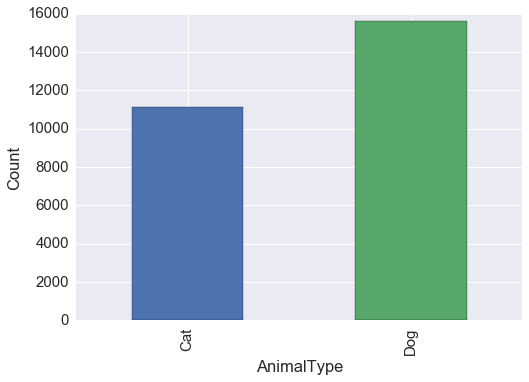

In [52]:
dftype = df[['AnimalID','AnimalType']].groupby(by='AnimalType').count()
dftype.columns=['Count']

sns.set(font_scale=1.5)
dftype.plot(kind='bar', color=palette, legend=None)
_ = plt.ylabel(dftype.columns[0])

## Age of animals at outcome

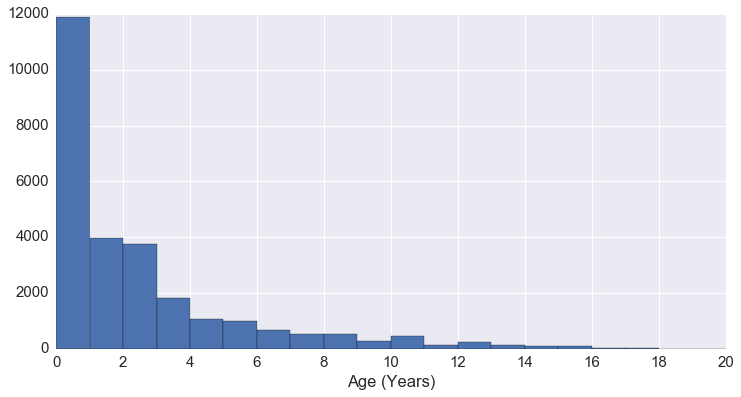

In [21]:
sns.set(font_scale=1.5)

seryears = (1/365)*df['AgeuponOutcome']
seryears.hist(bins=20, figsize=(12,6))
a = plt.xlabel('Age (Years)')
a = plt.xticks(range(0,22,2))

## Animal outcomes by month of year and time of day

In [14]:
df['DateTime'] = pd.to_datetime(df['DateTime'], infer_datetime_format=True)
# df.drop('Date', inplace=True, axis=1)

In [15]:
# df.plot(x='DateTime', y=)
df['YearMonth'] = df['DateTime'].apply(lambda x: str(x.strftime('%Y'))+'-'+str(x.strftime('%m')))
df['TimeofDay'] = df['DateTime'].apply(lambda x: str(x.strftime('%H')+':00'))
dfym = df[['YearMonth','AnimalID']].groupby(by='YearMonth').count()
dfym.columns = ['Count']
dftod = df[['TimeofDay','AnimalID']].groupby(by='TimeofDay').count()
dftod.columns = ['Count']

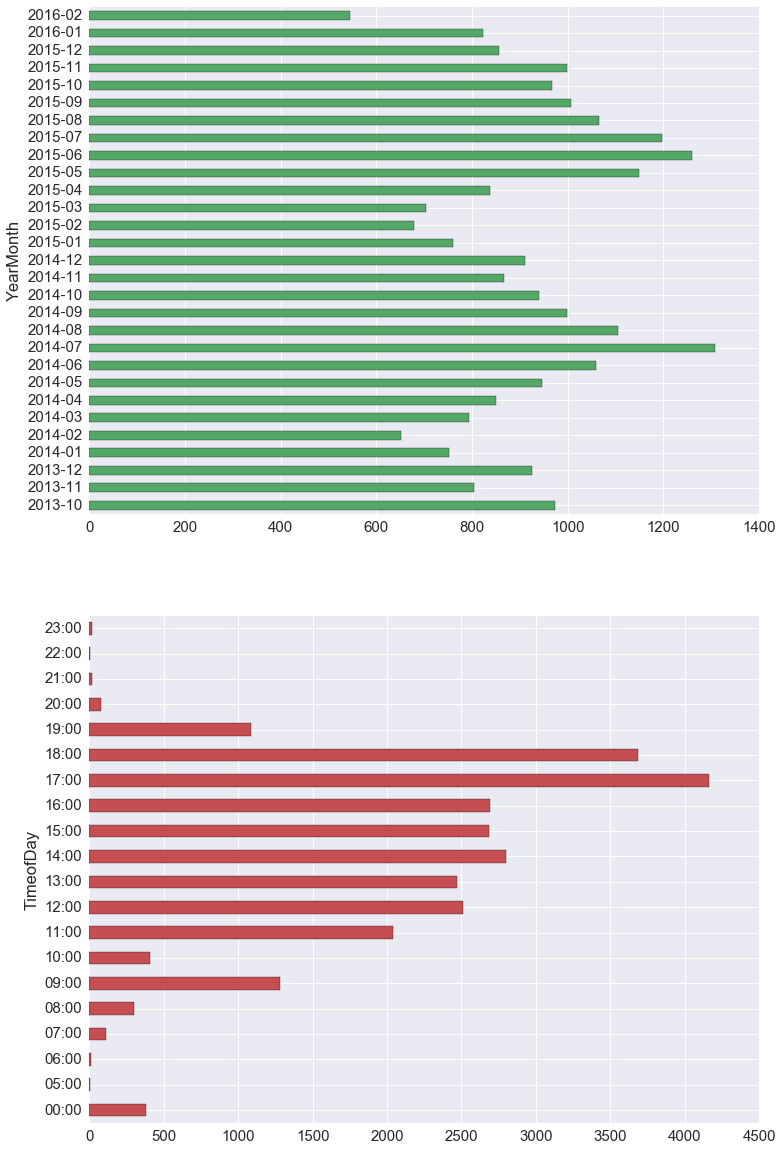

In [51]:
# Seasonality

f, axes = plt.subplots(2,1,figsize=(12,20))
_ = dfym.plot(kind='barh', color=palette[1], ax=axes[0], legend=None)
_ = dftod.plot(kind='barh', color=palette[2], ax=axes[1], legend=None)

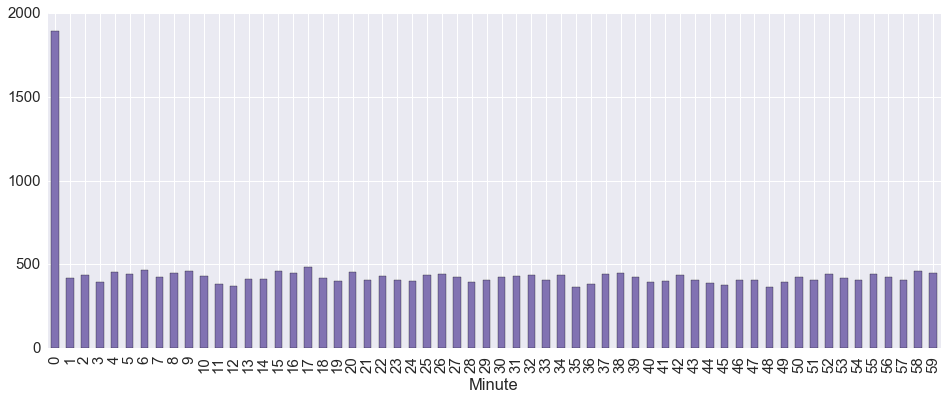

In [141]:
# Do minutes matter?

sermin = df['DateTime'].dt.minute
sermin = sermin.astype(int)
dfmin = pd.concat([df['AnimalID'], sermin], axis=1)
dfmin.columns = ['AnimalID', 'Minute']
dfmingroup = dfmin[['Minute','AnimalID']].groupby(by='Minute').count()
dfmingroup.columns = ['Count']
_ = dfmingroup.plot(kind='bar', color=palette[3], legend=None, figsize=(16,6))

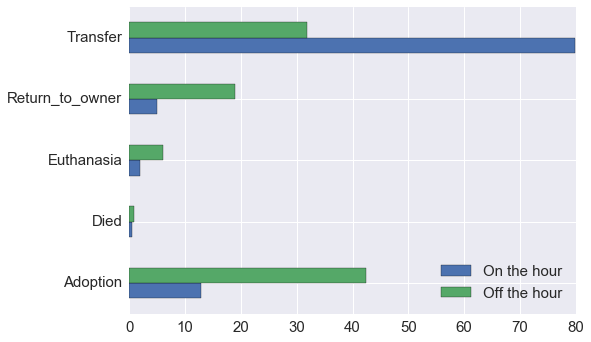

In [177]:
# What are the outcomes for on the hour times?
dfmin = pd.concat([df['OutcomeType'], sermin], axis=1)
dfmin.columns = ['OutcomeType', 'Minute']
serminout = dfmin['OutcomeType'][dfmin['Minute']==0].value_counts(normalize=True, ascending=True)*100
sernominout = dfmin['OutcomeType'][dfmin['Minute']!=0].value_counts(normalize=True, ascending=True)*100
dfminout = pd.concat([serminout, sernominout], axis=1)
dfminout.columns=['On the hour', 'Off the hour']
_ = dfminout.plot(kind='barh')

## Breakdown of dog breeds and outcomes

In [4]:
# Create dog-only dataframe (no cats)
df['Breed'] = df['Breed'].str.lower()
dfdog = df[df['AnimalType']=='Dog'].copy()

In [142]:
# Define function to select dog breeds

def selbreed(dfdog, substr):
    dfdog[substr] = dfdog['Breed'].str.contains(substr)
    ser = dfdog[[substr, 'AnimalID']].groupby(by=substr).count()
    seroutcome = dfdog['OutcomeType'][dfdog[substr]==True].value_counts(normalize=True, ascending=True)*100
    sernooutcome = dfdog['OutcomeType'][dfdog[substr]==False].value_counts(normalize=True, ascending=True)*100
    dfout = pd.concat([seroutcome, sernooutcome], axis=1)
    dfout.columns = [substr, 'Others']
    f, axes = plt.subplots(2,1,figsize=(10,16))
    ser.plot(kind='bar', legend=None, ax=axes[0])
    axes[0].set_title('Is animal a {0}?'.format(substr))
    axes[0].set_xlabel('')
    dfout.plot.barh(color=[palette[2], palette[0]], ax=axes[1])
    axes[1].set_xlabel('Frequency of occurrence (%)')
    axes[1].set_title('Outcomes for {0}'.format(substr))
    return ser, dfout

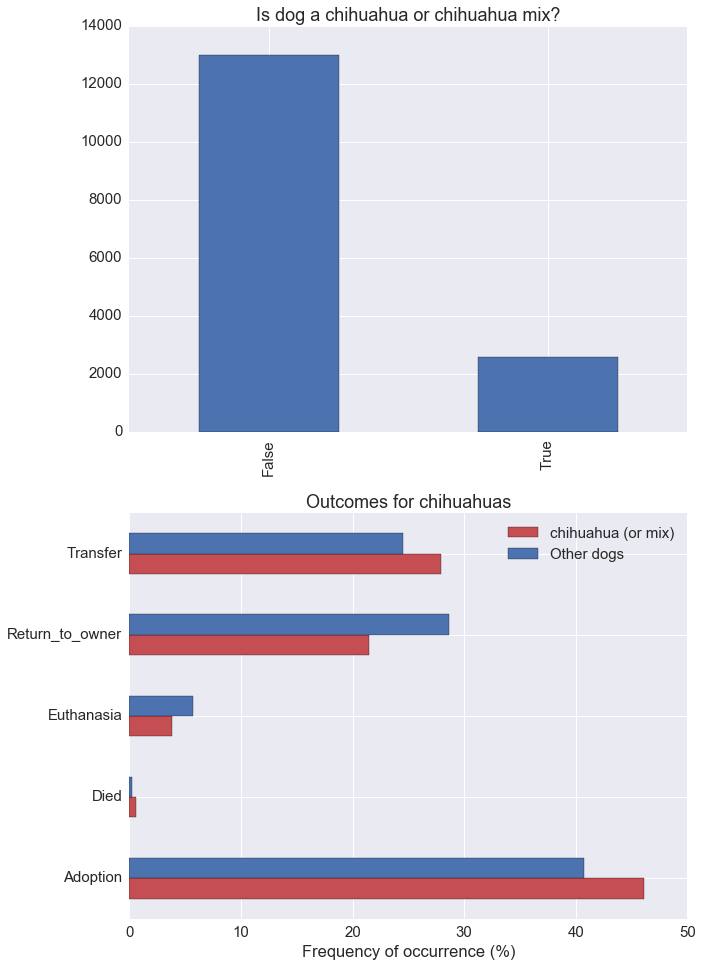

In [107]:
# What about chihuahuas?

serc, dfoutc = selbreed(dfdog, 'chihuahua')

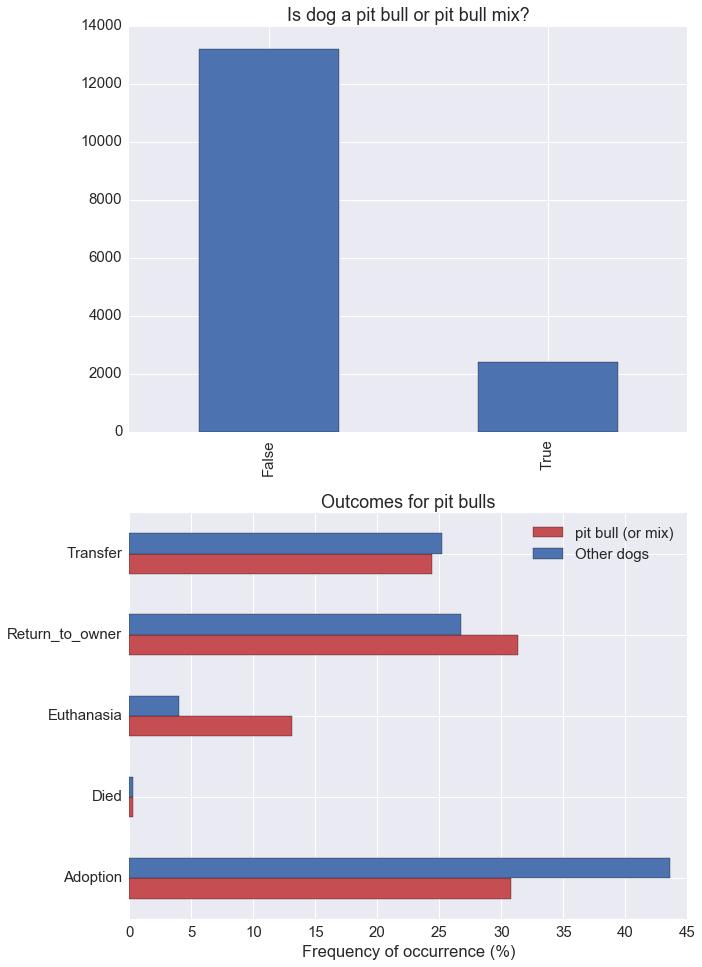

In [109]:
serpb, dfoutpb = selbreed(dfdog, 'pit bull')

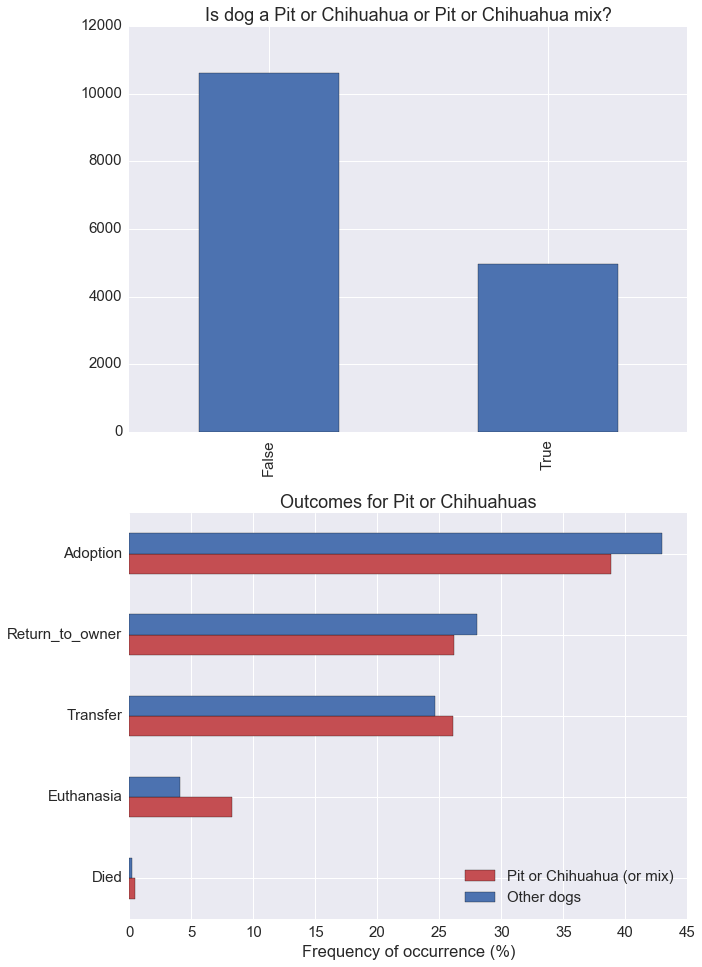

In [114]:
# Both chihuahuas and pit bulls vs other dogs

substr = 'Pit or Chihuahua'
dfdog[substr] = dfdog['Breed'].str.contains('pit bull') | dfdog['Breed'].str.contains('chihuahua')
ser = dfdog[[substr, 'AnimalID']].groupby(by=substr).count()
seroutcome = dfdog['OutcomeType'][dfdog[substr]==True].value_counts(normalize=True, ascending=True)*100
sernooutcome = dfdog['OutcomeType'][dfdog[substr]==False].value_counts(normalize=True, ascending=True)*100
dfout = pd.concat([seroutcome, sernooutcome], axis=1)
dfout.columns = [substr+' (or mix)', 'Other dogs']
f, axes = plt.subplots(2,1,figsize=(10,16))
ser.plot(kind='bar', legend=None, ax=axes[0])
axes[0].set_title('Is dog a {0} or {0} mix?'.format(substr))
axes[0].set_xlabel('')
_ = dfout.plot.barh(color=[palette[2], palette[0]], ax=axes[1])
_ = axes[1].legend(loc='lower right')
_ = axes[1].set_xlabel('Frequency of occurrence (%)')
_ = axes[1].set_title('Outcomes for {0}s'.format(substr))

#### This analysis suggests breeds may be simplified into pit bulls and chihuahuas vs other dogs.

In [91]:
# What about unidentified breeds? (There are none actually)
print(len(dfdog))
print(len(dfdog[dfdog['Breed'].isnull()]))

15595
0


In [121]:
# What about pure breeds (not pit bulls or chihuahuas)

mask = dfdog['Breed'].str.contains('/') | dfdog['Breed'].str.contains('mix') | \
        dfdog['Breed'].str.contains('pit bull')| dfdog['Breed'].str.contains('chihuahua')
print(len(dfdog[~(mask)]))
print(dfdog['Breed'][~(mask)].unique())

973
['cairn terrier' 'beagle' 'english foxhound' 'lhasa apso'
 'dachshund longhair' 'maltese' 'siberian husky' 'great dane'
 'chesa bay retr' 'german shepherd' 'english pointer' 'cocker spaniel'
 'shih tzu' 'dachshund' 'anatol shepherd' 'labrador retriever'
 'english bulldog' 'basset hound' 'boxer' 'miniature poodle'
 'doberman pinsch' 'harrier' 'border collie' 'vizsla' 'yorkshire terrier'
 'bull terrier' 'jack russell terrier' 'pekingese' 'miniature schnauzer'
 'rottweiler' 'great pyrenees' 'australian shepherd' 'greyhound'
 'bernese mountain dog' 'pembroke welsh corgi' 'australian cattle dog'
 'shetland sheepdog' 'weimaraner' 'miniature pinscher' 'boston terrier'
 'carolina dog' 'golden retriever' 'pug' 'dogo argentino' 'cavalier span'
 'staffordshire' 'rat terrier' 'akita' 'chow chow' 'american foxhound'
 'dachshund wirehair' 'parson russell terrier' 'dalmatian'
 'old english sheepdog' 'american bulldog' 'catahoula' 'chinese sharpei'
 'plott hound' 'german shorthair pointer' 'rhod r

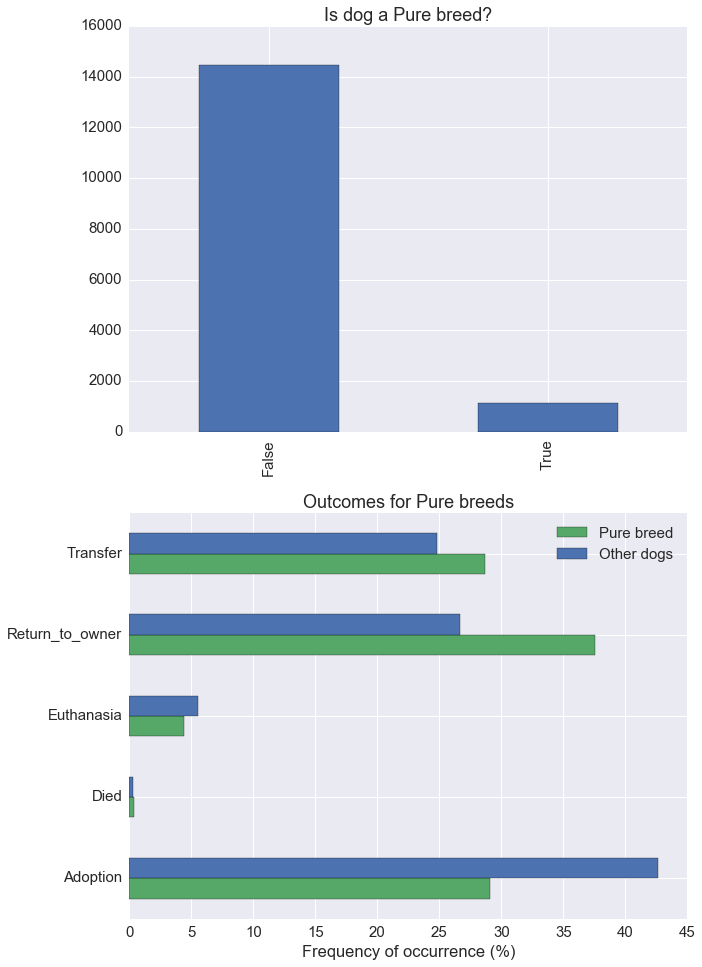

In [7]:
substr = 'Pure breed'
mask = dfdog['Breed'].str.contains('/') | dfdog['Breed'].str.contains('mix')
    
dfdog[substr] = ~(mask)
ser = dfdog[[substr, 'AnimalID']].groupby(by=substr).count()
seroutcome = dfdog['OutcomeType'][dfdog[substr]==True].value_counts(normalize=True, ascending=True)*100
sernooutcome = dfdog['OutcomeType'][dfdog[substr]==False].value_counts(normalize=True, ascending=True)*100
dfout = pd.concat([seroutcome, sernooutcome], axis=1)
dfout.columns = [substr, 'Other dogs']
f, axes = plt.subplots(2,1,figsize=(10,16))
ser.plot(kind='bar', legend=None, ax=axes[0])
axes[0].set_title('Is dog a {0}?'.format(substr))
axes[0].set_xlabel('')
_ = dfout.plot.barh(color=[palette[1], palette[0]], ax=axes[1])
_ = axes[1].legend(loc='best')
_ = axes[1].set_xlabel('Frequency of occurrence (%)')
_ = axes[1].set_title('Outcomes for {0}s'.format(substr))

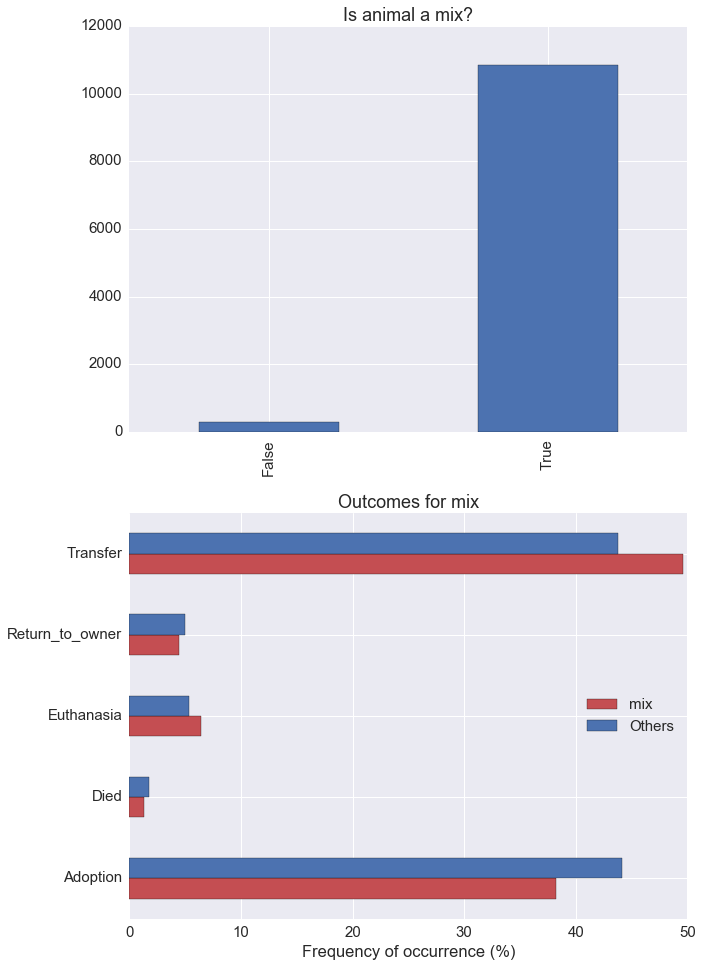

In [143]:
# What about purebreed vs mix for cats?

dfcat = df[df['AnimalType']=='Cat'].copy()

sercat, dfoutcat = selbreed(dfcat, 'mix')

## Breakdown of outcomes by animal color

In [166]:
def selcolor(df, substr, searchstr):
    animal = df['AnimalType'].unique()[0]
    mask = df['Color'].str.contains(searchstr)
    df[substr] = ~(mask)
    ser = df[[substr, 'AnimalID']].groupby(by=substr).count()
    seroutcome = df['OutcomeType'][df[substr]==True].value_counts(normalize=True, ascending=True)*100
    sernooutcome = df['OutcomeType'][df[substr]==False].value_counts(normalize=True, ascending=True)*100
    dfout = pd.concat([seroutcome, sernooutcome], axis=1)
    dfout.columns = [substr, 'Others']
    f, axes = plt.subplots(2,1,figsize=(10,16))
    ser.plot(kind='bar', legend=None, ax=axes[0])
    axes[0].set_title('Is {0} a {1}?'.format(animal, substr))
    axes[0].set_xlabel('')
    dfout.plot.barh(color=[palette[2], palette[0]], ax=axes[1])
    axes[1].set_xlabel('Frequency of occurrence (%)')
    axes[1].set_title('Outcomes for {0} {1}s'.format(substr, animal))
    return ser, dfout

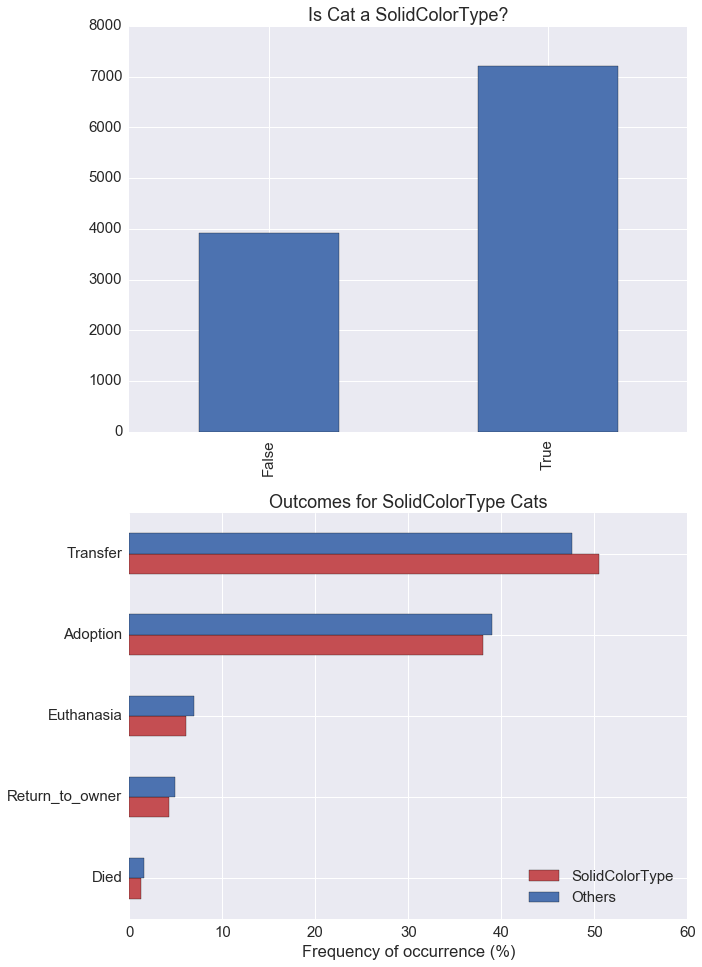

In [159]:
sercatclr, dfoutcatclr = selcolor(dfcat, 'SolidColorType', '/')

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


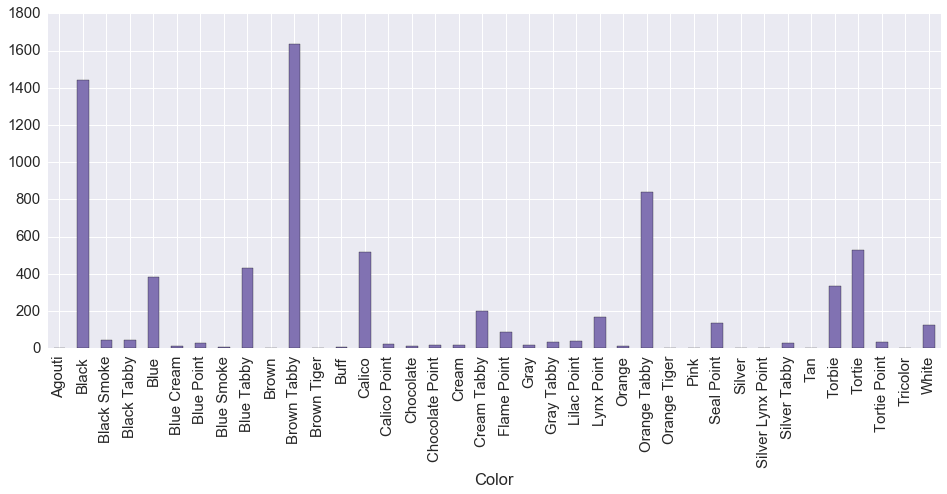

In [156]:
# Solid color type distribution
mask = df['Color'].str.contains('/')
dfmask = dfcat[~(mask)]
dfsolidcat = dfmask[['Color','AnimalID']].groupby(by='Color').count()
dfsolidcat.columns = ['Count']
_ = dfsolidcat.plot(kind='bar', color=palette[3], legend=None, figsize=(16,6))

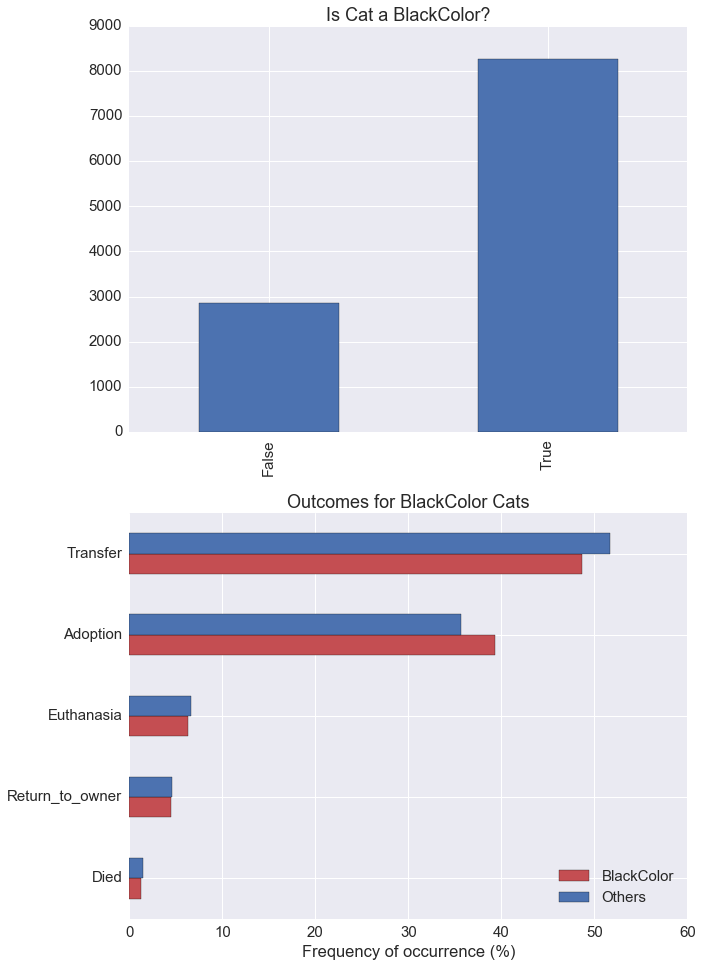

In [162]:
# Black cats?

sercatclr, dfoutcatclr = selcolor(dfcat, 'BlackColor', 'Black')

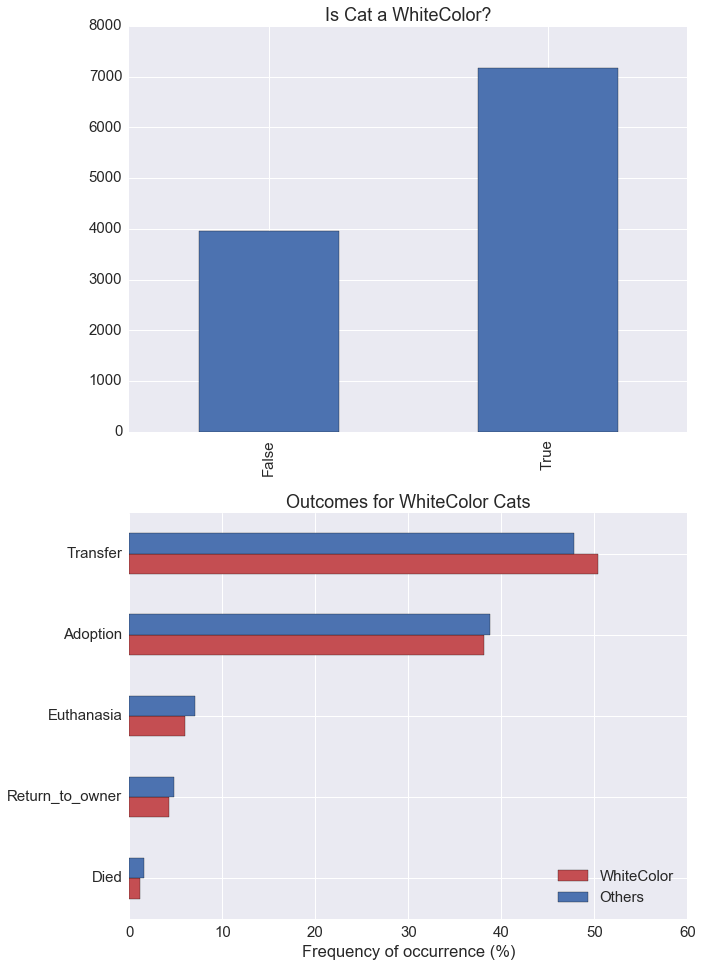

In [163]:
# White cats?

sercatclr, dfoutcatclr = selcolor(dfcat, 'WhiteColor', 'White')

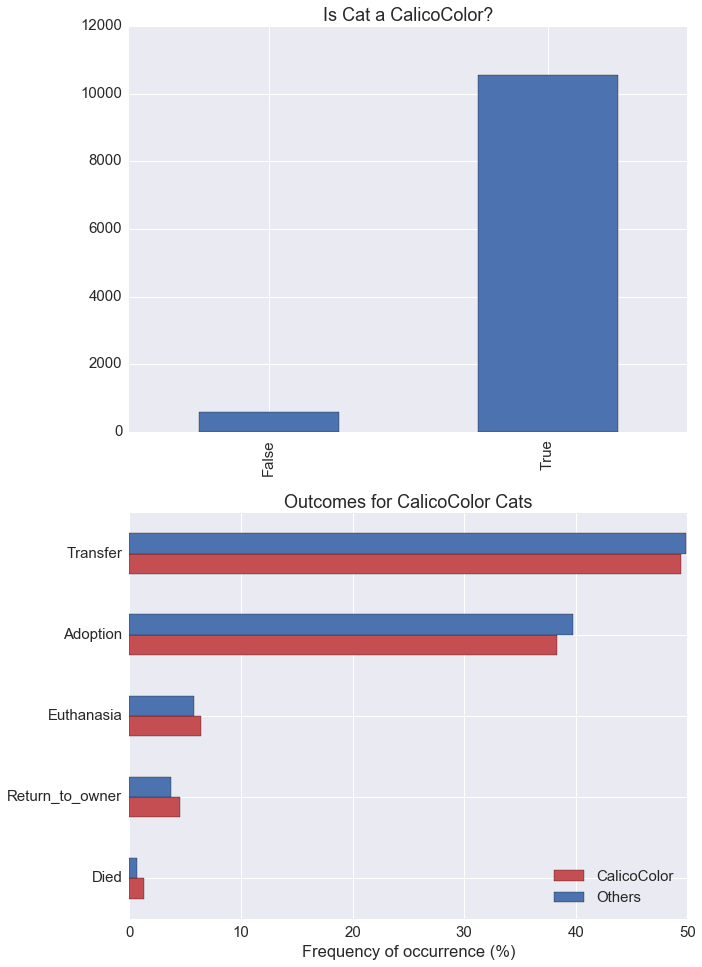

In [164]:
# Calico cats?

sercatclr, dfoutcatclr = selcolor(dfcat, 'CalicoColor', 'Calico')

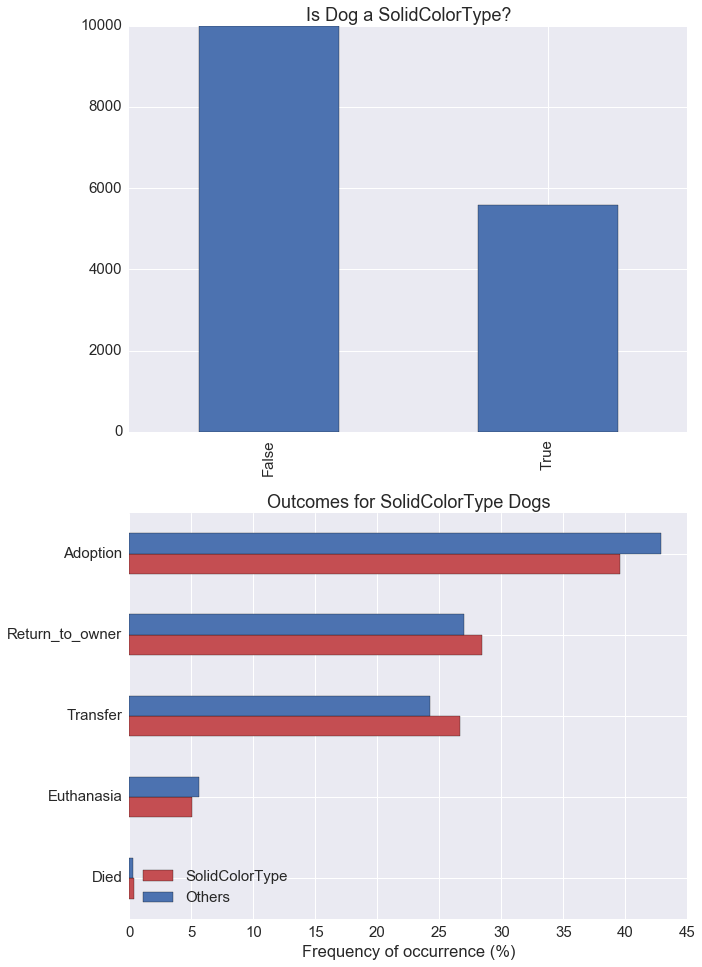

In [167]:
# What about solid color dogs?

serdogclr, dfoutdogclr = selcolor(dfdog, 'SolidColorType', '/')

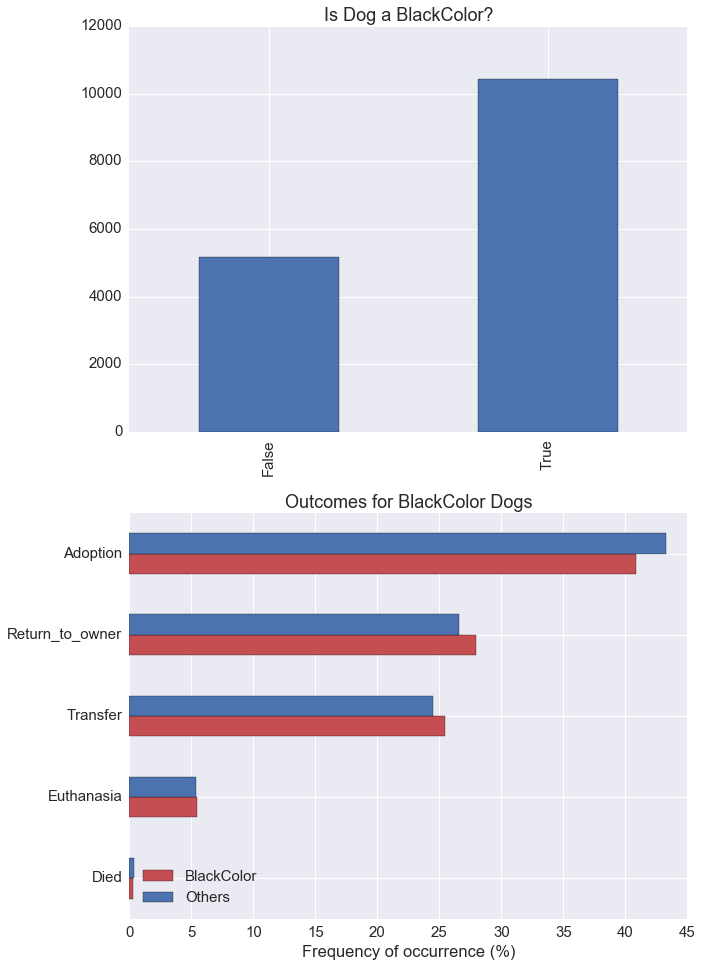

In [168]:
# Black dogs?

serdogclr, dfoutdogclr = selcolor(dfdog, 'BlackColor', 'Black')

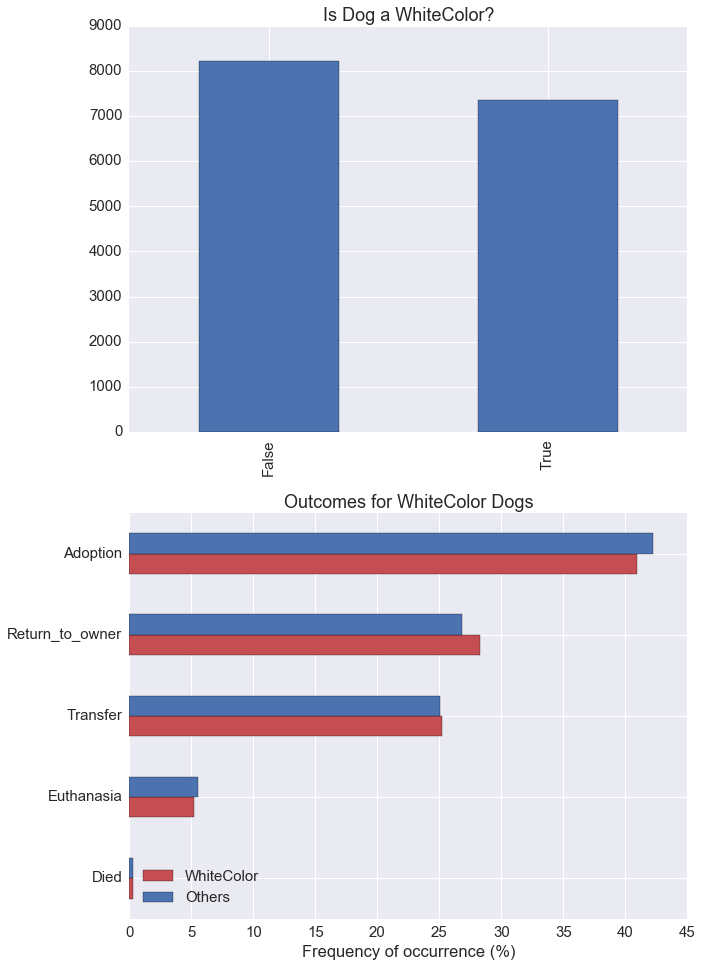

In [169]:
# White dogs? 

serdogclr, dfoutdogclr = selcolor(dfdog, 'WhiteColor', 'White')

In [170]:
# Are there unidentified colors? (Answer: No)

len(df[df['Color'].isnull()])

0

## Breakdown of outcomes by sex

In [195]:
# What are the outcomes for on the hour times?

# dfmin = pd.concat([df['OutcomeType'], sermin], axis=1)
# dfmin.columns = ['OutcomeType', 'Minute']
# serminout = dfmin['OutcomeType'][dfmin['Minute']==0].value_counts(normalize=True, ascending=True)*100
# sernominout = dfmin['OutcomeType'][dfmin['Minute']!=0].value_counts(normalize=True, ascending=True)*100
# dfminout = pd.concat([serminout, sernominout], axis=1)
# dfminout.columns=['On the hour', 'Off the hour']
# _ = dfminout.plot(kind='barh')

# ser = df['SexuponOutcome'].value_counts()
dfgroup = df[['SexuponOutcome', 'OutcomeType', 'AnimalID']].groupby(['SexuponOutcome', 'OutcomeType']).count()
dfgroup.columns=['Count']
# dfgroup.plot(kind='barh', stacked=True)
dfgroup

Count
SexuponOutcome OutcomeType           
Intact Female  Adoption           203
               Died                56
               Euthanasia         401
               Return_to_owner    301
               Transfer          2550
Intact Male    Adoption           158
               Died                79
               Euthanasia         477
               Return_to_owner    477
               Transfer          2334
Neutered Male  Adoption          5222
               Died                19
               Euthanasia         344
               Return_to_owner   2247
               Transfer          1947
Spayed Female  Adoption          5186
               Died                18
               Euthanasia         232
               Return_to_owner   1748
               Transfer          1636
Unknown        Died                25
               Euthanasia         101
               Return_to_owner     12
               Transfer           955

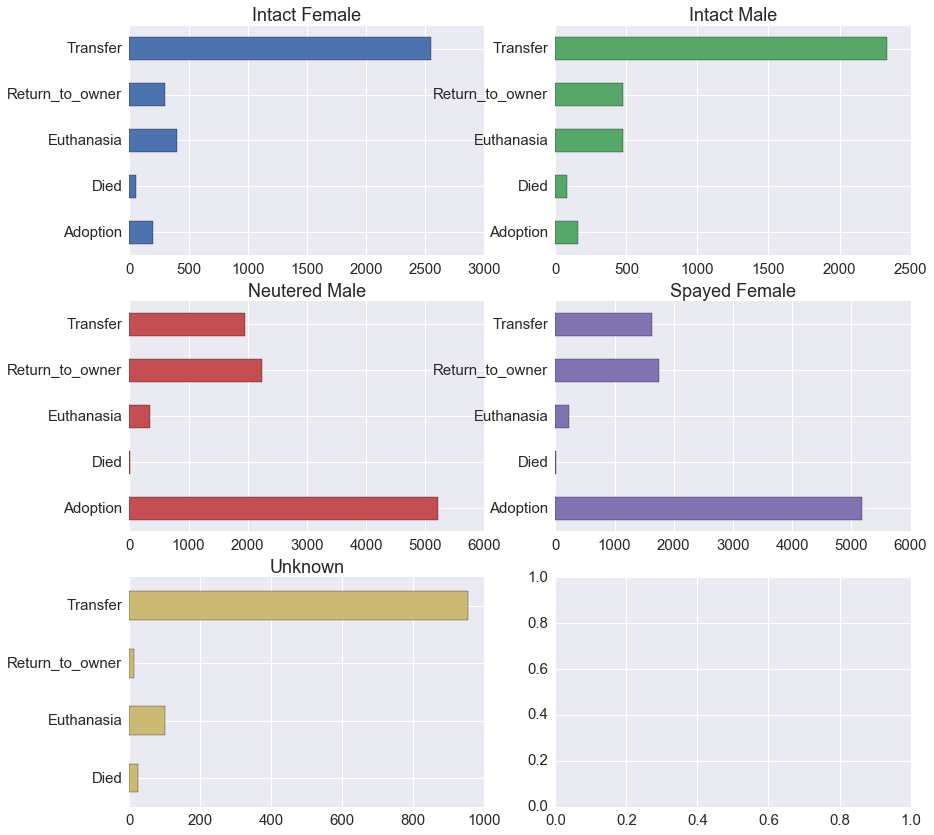

In [215]:
# visualize outcomes by sex
f, axes = plt.subplots(3,2, figsize=(14,14))
for i, top in enumerate(list(dfgroup.index.levels[0])):
    x = i//2
    y= i%2
    dfgroup.loc[top].plot(kind='barh', color=palette[i], legend=None, ax=axes[x,y])
    axes[x,y].set_ylabel('')
    axes[x,y].set_title(top)

________________________________________________________________________________
Training GBRT...
done.
________________________________________________________________________________
Convenience plot with ``partial_dependence_plots``
________________________________________________________________________________
Custom 3d plot via ``partial_dependence``


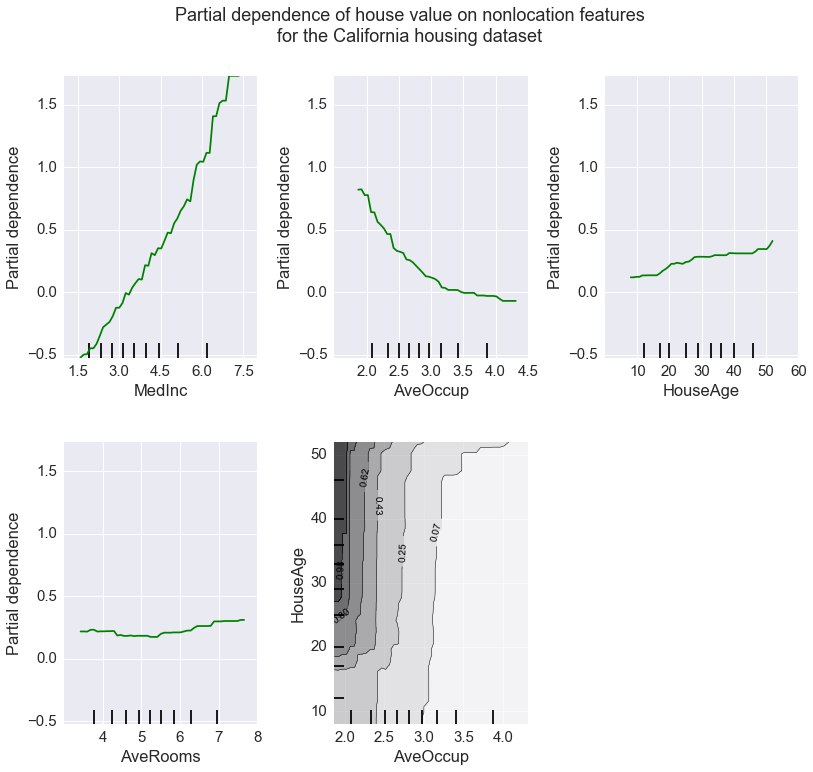

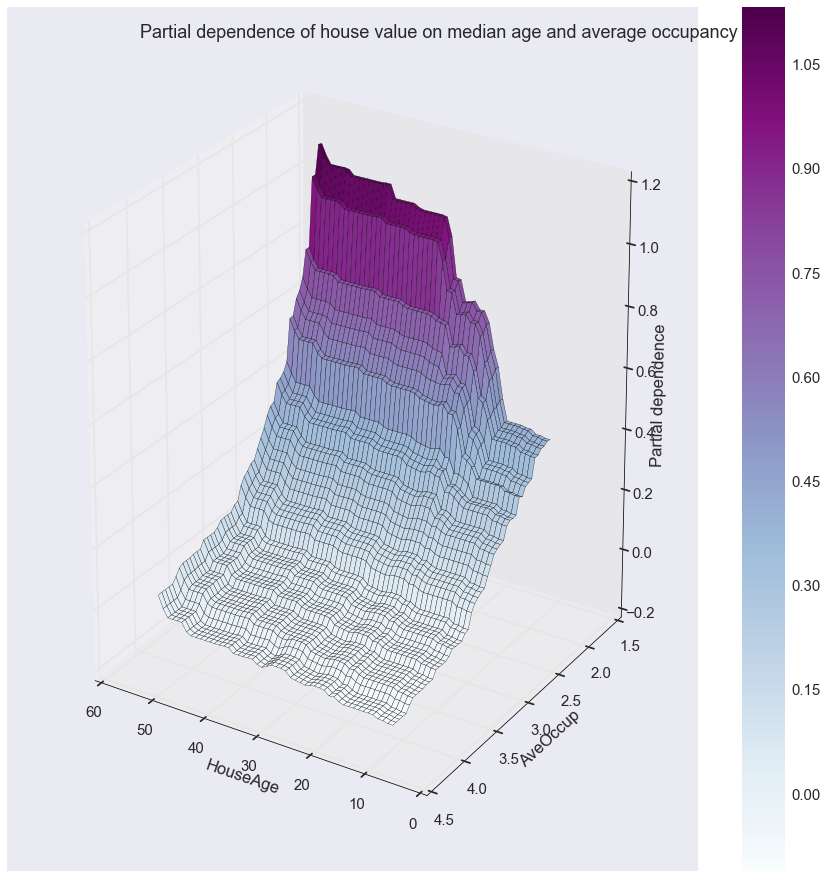

In [219]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.datasets.california_housing import fetch_california_housing


def main():
    cal_housing = fetch_california_housing()

    # split 80/20 train-test
    X_train, X_test, y_train, y_test = train_test_split(cal_housing.data,
                                                        cal_housing.target,
                                                        test_size=0.2,
                                                        random_state=1)
    names = cal_housing.feature_names

    print('_' * 80)
    print("Training GBRT...")
    clf = GradientBoostingRegressor(n_estimators=100, max_depth=4,
                                    learning_rate=0.1, loss='huber',
                                    random_state=1)
    clf.fit(X_train, y_train)
    print("done.")

    print('_' * 80)
    print('Convenience plot with ``partial_dependence_plots``')
    print

    features = [0, 5, 1, 2, (5, 1)]
    fig, axs = plot_partial_dependence(clf, X_train, features,
                                       feature_names=names,
                                       n_jobs=3, grid_resolution=50, figsize=(12,12))
    fig.suptitle('Partial dependence of house value on nonlocation features\n'
                 'for the California housing dataset')
    plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle

    print('_' * 80)
    print('Custom 3d plot via ``partial_dependence``')
    print
    fig = plt.figure(figsize=(12,12))

    target_feature = (1, 5)
    pdp, (x_axis, y_axis) = partial_dependence(clf, target_feature,
                                               X=X_train, grid_resolution=50)
    XX, YY = np.meshgrid(x_axis, y_axis)
    Z = pdp.T.reshape(XX.shape).T
    ax = Axes3D(fig)
    surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
    ax.set_xlabel(names[target_feature[0]])
    ax.set_ylabel(names[target_feature[1]])
    ax.set_zlabel('Partial dependence')
    #  pretty init view
    ax.view_init(elev=22, azim=122)
    plt.colorbar(surf)
    plt.suptitle('Partial dependence of house value on median age and '
                 'average occupancy')
    plt.subplots_adjust(top=0.9)

main()